# Astronomical Time Series Data

Francisco Förster Burón (UChile) & Ryan Trainor (F&M)

In [199]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use(['seaborn-v0_8-whitegrid', 'assets/class.mplstyle'])


# Part 1: Periodic models

Many types of astronomical data can be represented by periodic functions. For example, consider the RR Lyrae light curve below, which we can download from the astroML library:

Text(0, 0.5, 'amplitude')

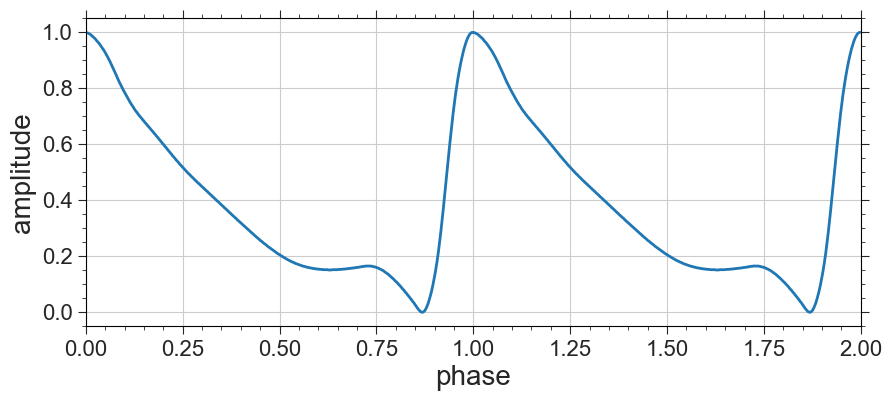

In [200]:
from scipy import fftpack
from astroML.datasets import fetch_rrlyrae_templates

templates = fetch_rrlyrae_templates()
x, y = templates['115r'].T
y = 1-y

phase = np.append(x,1+x)
amp = np.append(y,y)

fig,ax=plt.subplots()
ax.plot(phase,amp)
ax.set_xlim([0,2])
ax.set_xlabel('phase')
ax.set_ylabel('amplitude')

## Fourier modes

The Fourier expansion of a function $y(t)$ can be expressed by the following:

$$    
    y(t) = \sum_i^\infty A_i\cos(2\pi k_i t+\phi_i)
$$

Here the $A_i$'s are the amplitudes of the individual sinusoidal terms, the $k_i$'s are the frequencies of each term, and the $\phi_i$'s are the phases of each term.

For a discrete times series, we can use FFTs to quickly calculate the Fourier modes (i.e., the individual sinusoidal terms) from the data and to visualize them. Note that the $k=0$ mode has an infinite period (i.e., it is an additive constant), while the other modes have periods equal to $1/k$:

Text(0, 0.5, 'amplitude')

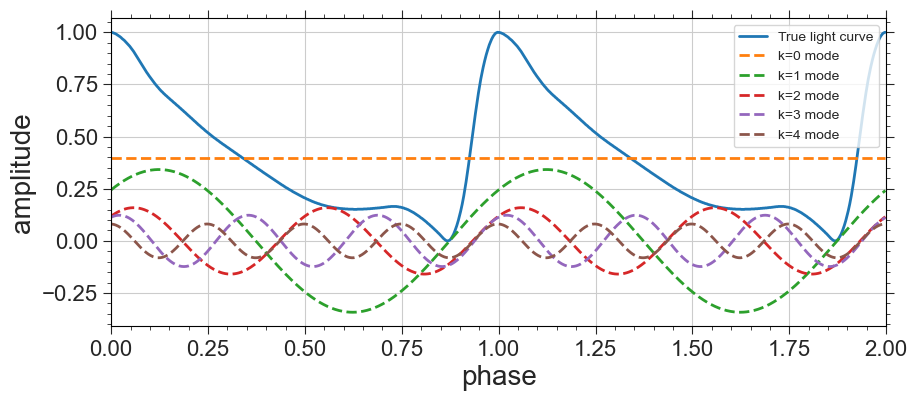

In [201]:
fig,ax=plt.subplots()
ax.plot(phase,amp,label='True light curve')

for k in range(5):
    y_fft = fftpack.fft(y) # compute the Fourier transform
    y_k = np.zeros(y_fft.shape,dtype=np.complex_) # create an array that is zero for all ks
    y_k[k] = y_fft[k] # restore only the kth mode
    y_k[-k] = y_fft[-k] # and the -kth mode
    y_fit = fftpack.ifft(y_k).real # compute the amplitudes from the kth Fourier component

    k_amp = np.append(y_fit,y_fit)
    ax.plot(phase,k_amp,ls='--',label=f'k={k} mode')

ax.legend()
ax.set_xlim([0,2])
ax.set_xlabel('phase')
ax.set_ylabel('amplitude')


## Power Spectral Distribution

The Power Spectral Distribution (PSD) is related to the Fourier transform $H(f)$ (or the discrete Fourier transform $H_k$) as the squared sum of the $f$ and $-f$ (or $k$ and $-k$) values:

$$
PSD(f) \equiv | H(f)|^2 + |H(-f)|^2
$$

This means that that the peaks in the PSD are related to the squared amplitudes of the individual Fourier modes in the above plot.

One important note about the PSD is that it represents the *amplitude* of each Fourier mode (i.e., the $A_i$'s), but the squaring means that all information about the *phase* of each mode (the $\phi_i$'s) is lost. This means that multiple functions $h(t)$ can have the same PSD, and the PSD alone is not sufficient to recover the original function uniquely.

/Users/rtrainor/opt/anaconda3/envs/astroML/lib/python3.12/site-packages/astroML/fourier.py:49: RuntimeWarning: divide by zero encountered in scalar divide
  Df = 1. / (N * Dt)
/Users/rtrainor/opt/anaconda3/envs/astroML/lib/python3.12/site-packages/astroML/fourier.py:52: RuntimeWarning: invalid value encountered in multiply
  f = Df * (np.arange(N) - N // 2)
/Users/rtrainor/opt/anaconda3/envs/astroML/lib/python3.12/site-packages/astroML/fourier.py:67: RuntimeWarning: invalid value encountered in multiply
  H *= np.exp(-2j * np.pi * t0 * f.reshape(shape))


Text(0, 0.5, 'PSD(k)')

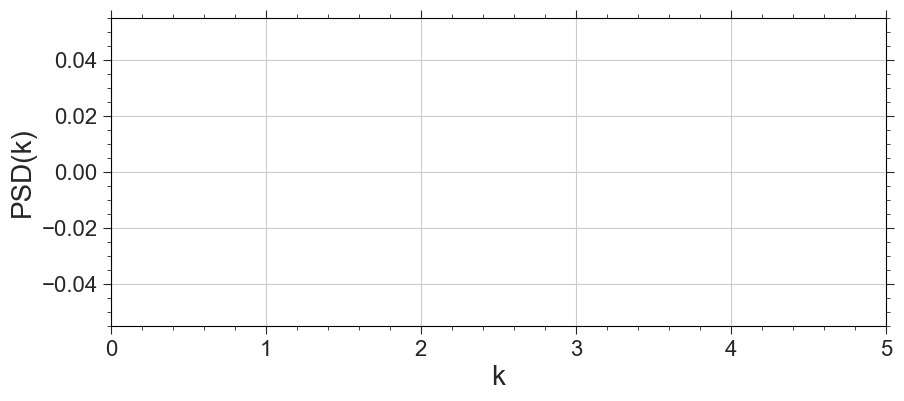

In [202]:
from astroML.fourier import PSD_continuous

def repeat_lightcurve(y,t,n,period=1):
    '''Repeats the lightcurve n times and extends time array to match.'''
    new_t = []
    for i in range(n):
        new_t.append(np.asarray(t)+i*period)
    new_y = list(y) * n
    return np.asarray(new_t).flatten(),np.asarray(new_y)

# repeat the lightcurve 10x to mimic periodic behavior
x_rpt,y_rpt = repeat_lightcurve(x,y,10)
fk, PSD = PSD_continuous(x_rpt,y_rpt)

fig,ax=plt.subplots()
ax.plot(fk,PSD)
ax.set_xlim([0,5])
ax.set_xlabel('k')
ax.set_ylabel('PSD(k)')


Another way of visualizing the Fourier representation of a function is to consider its *truncated* Fourier series representation: the approximation of the function given by the first $n$ terms in the Fourier series. Below, we see the truncated Fourier representation of our light curve for the first 1, 3, and 8 terms:

Text(0, 0.5, 'amplitude')

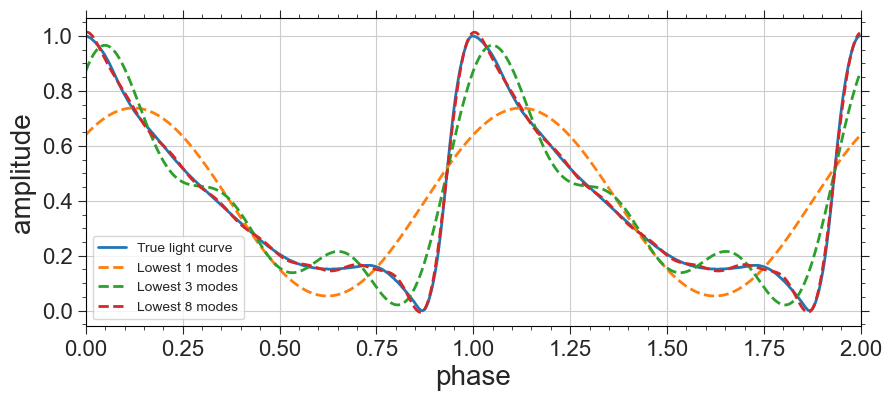

In [203]:
fig,ax=plt.subplots()
ax.plot(phase,amp,label='True light curve')

for k in [1,3,8]:
    y_fft = fftpack.fft(y) # compute the Fourier transform
    y_fft[k + 1:-k] = 0 # zero-out frequencies higher than k
    y_fit = fftpack.ifft(y_fft).real # compute the amplitudes from the truncated series

    trunc_amp = np.append(y_fit,y_fit)
    ax.plot(phase,trunc_amp,ls='--',label=f'Lowest {k} modes')

ax.legend()
ax.set_xlim([0,2])
ax.set_xlabel('phase')
ax.set_ylabel('amplitude')


## y(t) and the PSD

The following cells provide more examples of relating the properties of the function $y(t)$ and its PSD. The next two cells are sums of two sinusoids (red + blue = black), so their PSDs are delta functions whose heights are related to the relative amplitudes of the corresponding frequency in the original function.

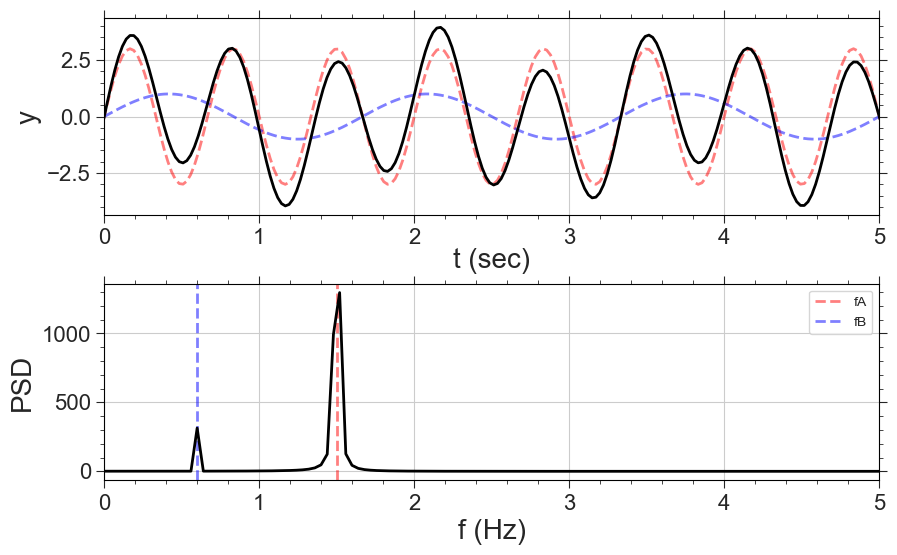

In [204]:
t = np.linspace(-10,15,1024)
fA = 1.5
yA = np.sin(2*np.pi*fA*t)
fB = 0.6
yB = np.sin(2*np.pi*fB*t)

y = 3*yA + 1*yB
fk, PSD = PSD_continuous(t,y)

fig,axs=plt.subplots(nrows=2,figsize=(10,6))
axs[0].plot(t,3*yA,'r--',alpha=0.5)
axs[0].plot(t,1*yB,'b--',alpha=0.5)
axs[0].plot(t,y,'k-')
axs[0].set_xlabel('t (sec)',labelpad=0)
axs[0].set_ylabel('y')
axs[0].set_xlim([0,5])

axs[1].axvline(fA,color='r',ls='--',label='fA',alpha=0.5)
axs[1].axvline(fB,color='b',ls='--',label='fB',alpha=0.5)
axs[1].plot(fk,PSD,'k-')
axs[1].set_xlabel('f (Hz)')
axs[1].set_ylabel('PSD') 
axs[1].set_xlim([0,5])
axs[1].legend()
fig.subplots_adjust(hspace=0.35)

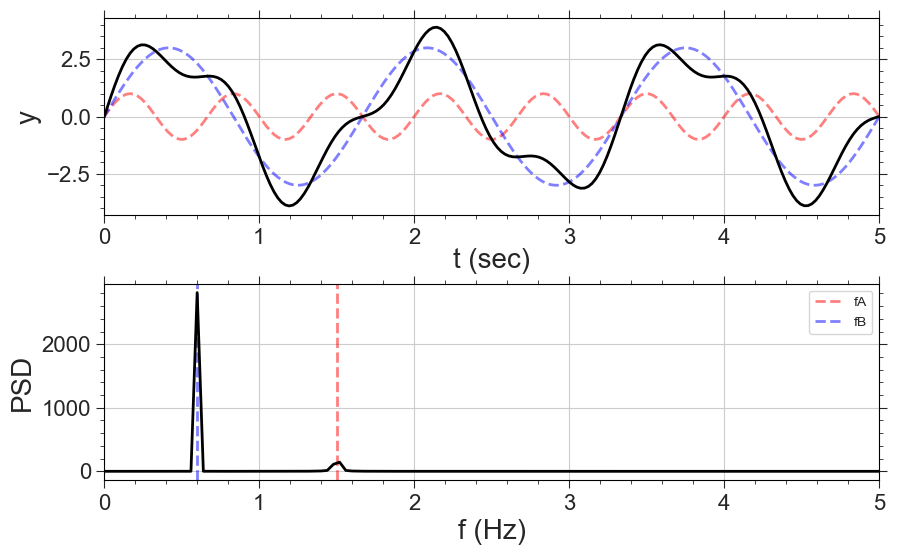

In [205]:
y = 1*yA + 3*yB
fk, PSD = PSD_continuous(t,y)

fig,axs=plt.subplots(nrows=2,figsize=(10,6))
axs[0].plot(t,1*yA,'r--',alpha=0.5)
axs[0].plot(t,3*yB,'b--',alpha=0.5)
axs[0].plot(t,y,'k-')
axs[0].set_xlabel('t (sec)',labelpad=0)
axs[0].set_ylabel('y')
axs[0].set_xlim([0,5])

axs[1].axvline(fA,color='r',ls='--',alpha=0.5,label='fA')
axs[1].axvline(fB,color='b',ls='--',alpha=0.5,label='fB')
axs[1].plot(fk,PSD,'k-')
axs[1].set_xlabel('f (Hz)')
axs[1].set_ylabel('PSD') 
axs[1].set_xlim([0,5])
axs[1].legend()
fig.subplots_adjust(hspace=0.35)

In the example below, the two curves are sums of sinusoids of the same two frequencies as each other, but the higher-frequency term in $y_A$ has a different phase than that of $y_B$. Since the PSD contains no phase information, both functions are represented by the same PSD despite having different functional behavior.

/var/folders/6r/klndhhws02j_5lsrsqgz31d40000gq/T/ipykernel_3713/3152552888.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend()


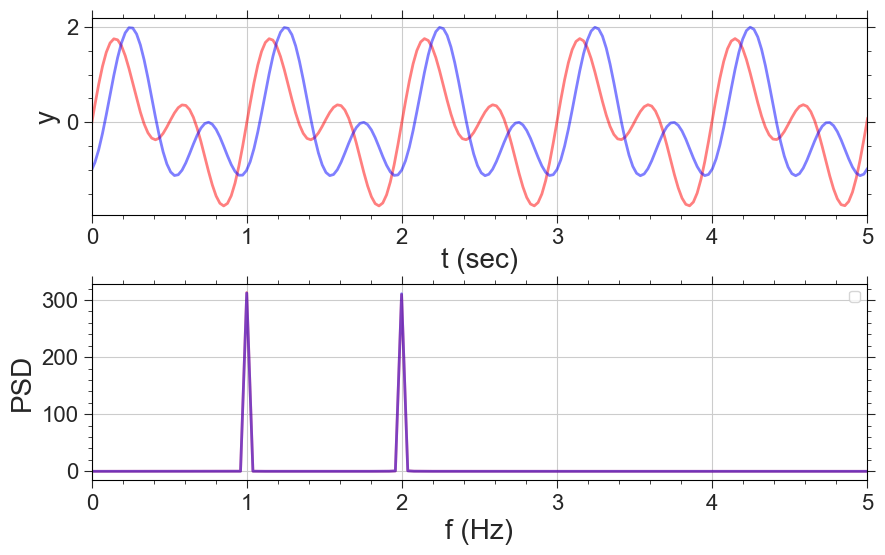

In [206]:
yA = np.sin(2*np.pi*t) + np.sin(4*np.pi*t)
yB = np.sin(2*np.pi*t) - np.cos(4*np.pi*t)
fkA, PSDA = PSD_continuous(t,yA)
fkB, PSDB = PSD_continuous(t,yB)

fig,axs=plt.subplots(nrows=2,figsize=(10,6))
axs[0].plot(t,yA,'r-',alpha=0.5)
axs[0].plot(t,yB,'b-',alpha=0.5)
axs[0].set_xlabel('t (sec)',labelpad=0)
axs[0].set_ylabel('y')
axs[0].set_xlim([0,5])

axs[1].plot(fkA,PSDA,'r-',alpha=0.5)
axs[1].plot(fkB,PSDB,'b-',alpha=0.5)
axs[1].set_xlabel('f (Hz)')
axs[1].set_ylabel('PSD') 
axs[1].set_xlim([0,5])
axs[1].legend()
fig.subplots_adjust(hspace=0.35)

## Discrete Fourier transforms and Nyquist sampling

The above examples have used discrete functions and FFTs to visualize Fourier transforms, but the discretized Fourier transform is only a good approximation to the analytic Fourier transform when the analytic function has been sampled at sufficiently high frequency to resolve its behavior.

Specifically, the function $h(t)$ must be *band-limited*, meaning that there exists a frequency $f_c$ above which the Fourier transform $H(f)$ is equal to zero:

$$
H(f>f_c)=H(f<-f_c)=0
$$

Assuming that $h(t)$ and $H(f)$ meet this condition, then the complete Fourier transform can be constructed accurately if and only if the function $h(t)$ is sampled at a rate greater than twice the Nyquist critical frequency $f_c$ (or equivalently, sampled at time steps shorter than $\Delta t=1/(2f_c)$). The cell below shows an example of an analytic sinusoidal function and discretization with $f>2f_c$.

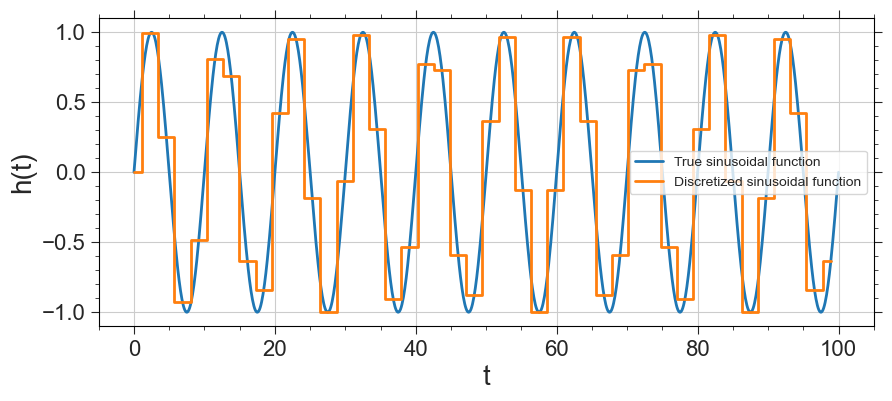

In [184]:
P = 10
dt = 2.3
tj = np.arange(0,10*P,dt)
yj = np.sin(2*np.pi*tj/P)

fig,ax=plt.subplots()
t = np.linspace(0,10*P,1000)
y = np.sin(2*np.pi*t/P)
ax.plot(t,y,label='True sinusoidal function')
ax.plot(tj,yj,drawstyle='steps-mid',label='Discretized sinusoidal function')
ax.set_xlabel('t')
ax.set_ylabel('h(t)')
ax.legend()

Furthermore, when an analytic function is well-sampled by the Nyquist criterion above, then the exact original function can be generated from the discretized signal using a technique known as Shannon interpolation (or sinc interpolation). The cell below defines a function for Shannon interpolation, and the following cell uses it to interpolate a discretized function. You can try different values of dt to see how the relationship of the sampling timestep dt and the period T impact the accuracy of the recovered function.

In [37]:
# Whittaker=Shannon FFT-based interpolation for band-limited data
def sinc_interpolation_fft(x: np.ndarray, s: np.ndarray, u: np.ndarray) -> np.ndarray:
    """
    Fast Fourier Transform (FFT) based sinc or bandlimited interpolation.
    
    Args:
        x (np.ndarray): signal to be interpolated, can be 1D or 2D
        s (np.ndarray): time points of x (*s* for *samples*) 
        u (np.ndarray): time points of y (*u* for *upsampled*)
        
    Returns:
        np.ndarray: interpolated signal at time points *u*
    """
    num_output = len(u)

    # Compute the FFT of the input signal
    X = np.fft.rfft(x)

    # Create a new array for the zero-padded frequency spectrum
    X_padded = np.zeros(num_output // 2 + 1, dtype=complex)

    # Copy the original frequency spectrum into the zero-padded array
    X_padded[:X.shape[0]] = X

    # Compute the inverse FFT of the zero-padded frequency spectrum
    x_interpolated = np.fft.irfft(X_padded, n=num_output)

    return x_interpolated * (num_output / len(s))

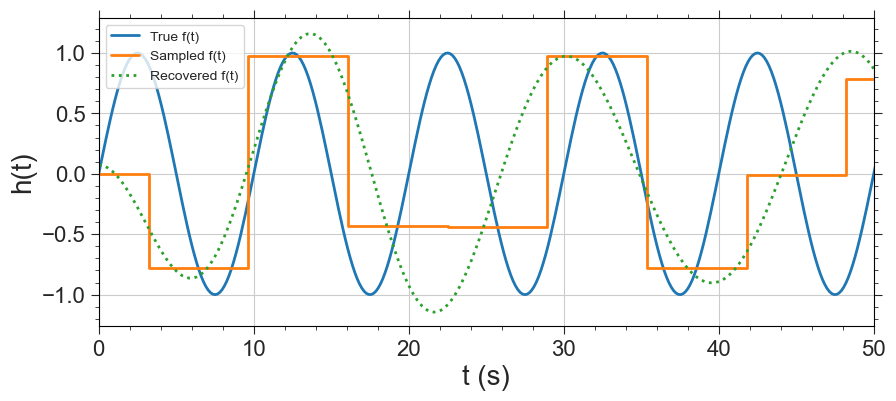

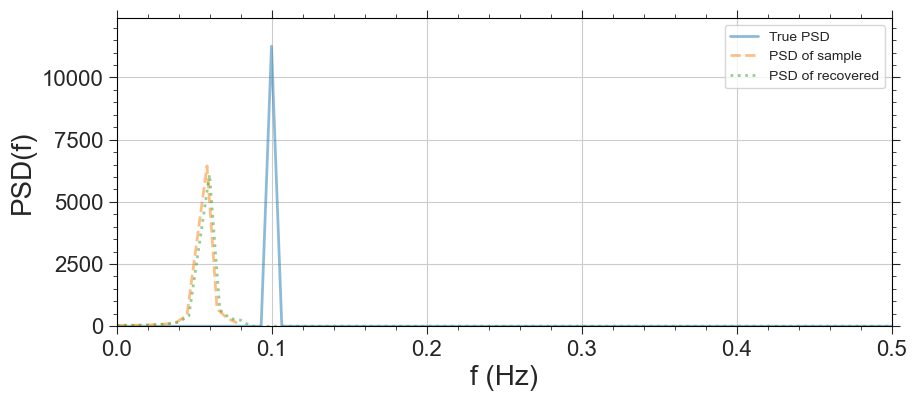

In [190]:
# dt = 4
dt = 6.43
# dt = 2.3
P = 10
N_P = 5

N_P_buff = 10
# t = np.linspace(-N_P_buff*P,(N_P+N_P_buff)*P,1000)
t = np.linspace(0,(N_P+N_P_buff)*P,1000)
y = np.sin(2*np.pi*t/P)

# tj=np.arange(-N_P_buff*P,(N_P+N_P_buff)*P,dt)
tj=np.arange(0,(N_P+N_P_buff)*P,dt)
if len(tj) % 2 !=0:
    tj=tj[:-1]

yj = np.sin(2*np.pi*tj/P)
y_fit = sinc_interpolation_fft(yj,tj,t)

fkj,PSDj = PSD_continuous(tj,yj)
fk_true,PSD_true = PSD_continuous(t,y)
fk_fit,PSD_fit = PSD_continuous(t,y_fit)

fig,ax=plt.subplots()
ax.plot(t,y,label='True f(t)')
ax.plot(tj,yj,drawstyle='steps-mid',label='Sampled f(t)')
ax.plot(t,y_fit,':',label='Recovered f(t)')
ax.set_xlim([0,N_P*P])
ax.set_xlabel('t (s)')
ax.set_ylabel('h(t)')
ax.legend()

fig,ax=plt.subplots()
ax.plot(fk_true,PSD_true,alpha=0.5,label='True PSD')
ax.plot(fkj,PSDj,alpha=0.5,ls='--',label='PSD of sample')
ax.plot(fk_fit,PSD_fit,alpha=0.5,ls=':',label='PSD of recovered')
ax.set_xlim([0,5/P])
ax.set_ylim([0,np.max(PSD_true)*1.1])
ax.set_xlabel('f (Hz)')
ax.set_ylabel('PSD(f)')
ax.legend()

Note that the cell above also compares the PSD of the original function and the discretized function (or rather, the more coarsely discretized function, since in both cases the function is discrete). When the discretized function is undersampled with respect to the Nyquist critical frequency, the sampling produces an effect called *aliasing* where power that was originally at frequencies $f>2f_c$ appears at lower frequencies in the sampled function, and the interpolated function matches the PSD of the undersampled function rather than the original.

## Fourier transforms and noise

Fourier transforms can also be used to extract periodic signals from noisy data. The example below shows a timeseries with periodic behavior as well as random noise. By adjusting the `noise` parameter and re-running the cell, you should find that the sinusoidal pattern is visible by eye with `noise = 0.2` (i.e., with gaussian noise equal to 20% of the signal amplitude), but that the signal appears to be swallowed by the noise with `noise = 2.0`. However, the Fourier PSD recovers the true frequency of the buried periodic signal even when it is not visible by eye.

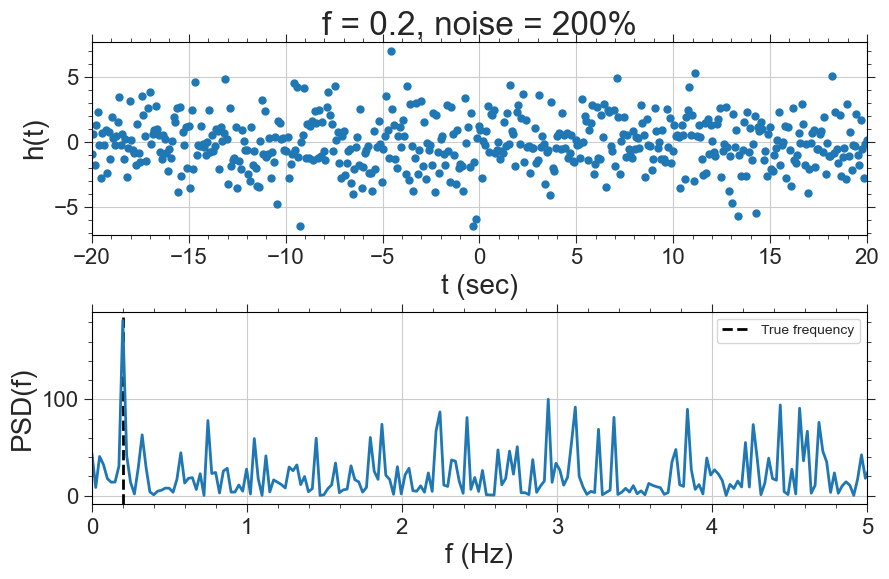

In [193]:
# Adjust the noise (as a fraction of the true signal amplitude) via the "noise" variable below

# noise = 0.2
noise = 2

f_true = 0.2

t=np.linspace(-20,20,512)
y=np.sin(2*np.pi*f_true*t)*np.exp(-t**2/(2*10**2))

y_noisy =y+ np.random.normal(0,noise,len(t))

f,PSD = PSD_continuous(t,y_noisy)

fig,axs=plt.subplots(nrows=2,figsize=(10,6))

axs[0].plot(t,y_noisy,'.')
axs[0].set_title(f'f = {f_true}, noise = {noise*100}%')
axs[0].set_xlabel('t (sec)')
axs[0].set_ylabel('h(t)')
axs[0].set_xlim([-20,20])

axs[1].axvline(f_true,color='k',ls='--',label='True frequency')
axs[1].plot(f,PSD)
axs[1].set_xlabel('f (Hz)')
axs[1].set_ylabel('PSD(f)') 
# axs[1].set_xlim([np.min(f),np.max(f)])
axs[1].set_xlim([0,5])
axs[1].legend()
fig.subplots_adjust(hspace=0.4)




Fourier transforms can also be used to extract the phase and shape of the spectrum by filtering out high-frequency noise. In the example below, the same noisy data is fit with a truncated Fourier series. If the truncated series is set to include the primary frequencies of the signal (in this case, f=0.2) and exclude higher frequencies (which are due to the gaussian noise), then the original signal becomes much easier to discern. However, if the Fourier series is truncated too early at (at f<0.2 in this case), then the true signal is filtered out along with the noise.

Text(0, 0.5, 'h(t)')

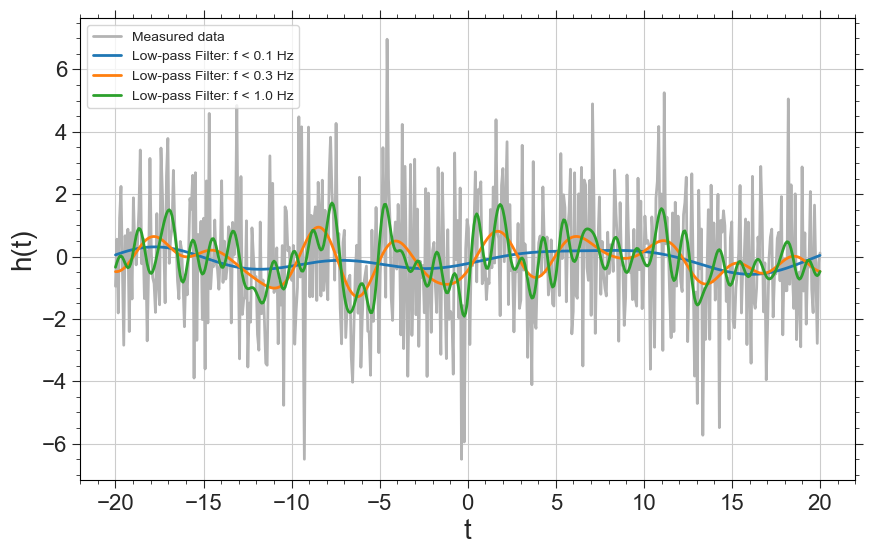

In [194]:
# Filter high-frequency noise from spectrum with Fourier modes

fig,ax=plt.subplots(figsize=(10,6))
ax.plot(t,y_noisy,'-',color='0.7',label='Measured data')

for fi in [0.1,0.3,1.0]:
    k = np.argmin(np.abs(f-fi))
    y_fft = fftpack.fft(y_noisy) # compute the Fourier transform
    y_fft[k + 1:-k] = 0 # zero-out frequencies higher than k
    y_fit = fftpack.ifft(y_fft).real # compute the amplitudes from the truncated series

    trunc_amp = y_fit
    ax.plot(t,trunc_amp,ls='-',label=f'Low-pass Filter: f < {fi} Hz')

ax.legend()
# ax.set_xlim([0,2])
ax.set_xlabel('t')
ax.set_ylabel('h(t)')


### Irregular time sampling

Key to the form of the discrete Fourier transform is the fact that the time series data $h(t)$ is assumed to be sampled evenly (i.e., the sampling or "window function" is a series of delta functions evenly spaced in time), in which case the frequency spectrum $H(f)$ is evenly sampled as well. However, for non-even time series, the discretized Fourier transform yields nonsensical results.

The example below includes time series from above sampled at 512 random (uniformly-distributed) times, rather than at equally-spaced intervals. While visually identical to the previous example, in this case the PSD yields nonsensical and unstable peaks that do not correspond to the input frequency.

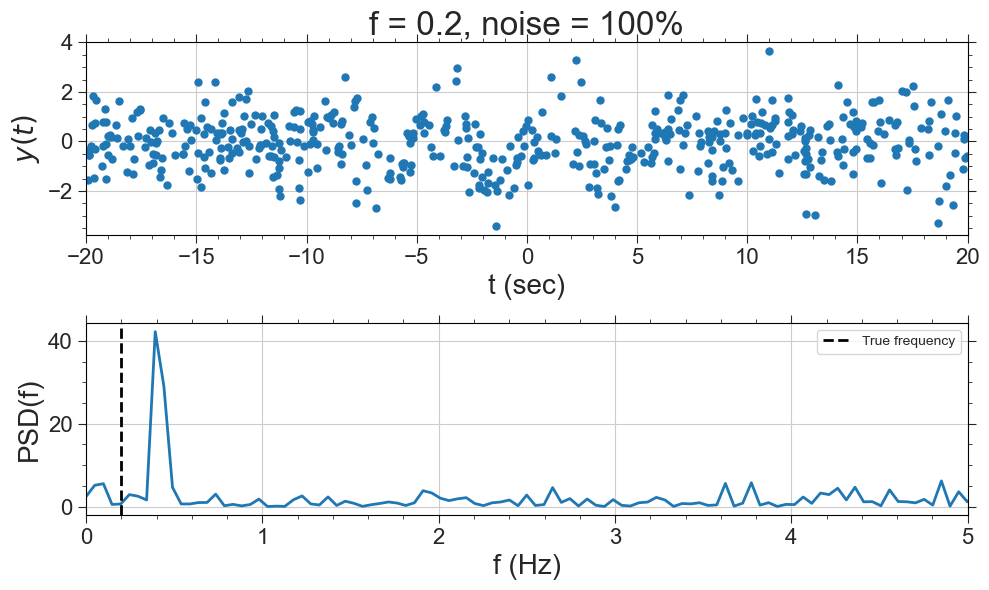

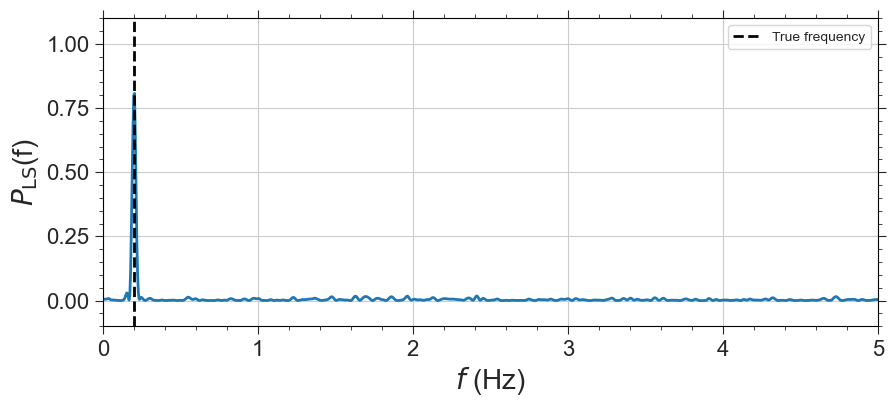

In [196]:
# np.random.seed(42)
f_true = 0.2

t=np.sort(20*np.random.uniform(-1,1,512))
y=np.sin(2*np.pi*f_true*t)*np.exp(-t**2/(2*10**2))

noise = 1
y_noisy = y + np.random.normal(0,noise,len(t))

f,PSD = PSD_continuous(t,y_noisy)

fig,axs=plt.subplots(nrows=2,figsize=(10,6))

axs[0].plot(t,y_noisy,'.')
axs[0].set_title(f'f = {f_true}, noise = {noise*100}%')
axs[0].set_xlabel('t (sec)')
axs[0].set_ylabel('$y(t)$')
axs[0].set_xlim([-20,20])

axs[1].plot(f,PSD)
axs[1].axvline(f_true,color='k',ls='--',label='True frequency')
axs[1].set_xlabel('f (Hz)')
axs[1].set_ylabel('PSD(f)') 
# axs[1].set_xlim([np.min(f),np.max(f)])
axs[1].set_xlim([0,5])
axs[1].legend()
fig.tight_layout()


from astropy.timeseries import LombScargle
omega,P_LS = LombScargle(t, y).autopower()
fig,ax=plt.subplots()

# ax.fill(omega, P_LS, fc='gray', ec='gray',label='Perfect sampling')
ax.plot(omega, P_LS)
ax.axvline(f_true,color='k',ls='--',label='True frequency')
ax.set_ylim(-0.1, 1.1)
ax.set_xlim(omega[0],omega[-1])
ax.set_xlabel('$f$ (Hz)')
ax.set_ylabel(r'$P_{\rm LS}$(f)')
ax.set_xlim([0,5])
ax.legend()


The second PSD-like plot is a Lomb-Scargle periodogram, which does recover the input frequency with high fidelity despite the unevenly-sampled data. Further examples of the Lomb-Scargle periodogram are given below.

## Lomb-Scargle periodograms

Lomb-Scargle periodograms can also recover periodic signals from more sparsely-sampled data with heteroscedastic errors, including data with extended periods with no measurements. The example below shows the effect of censoring a period of 20 days within a 100-day period, as well as the signal for a continuously-sampled signal with no uncertainty.

Text(0, 0.5, '$y(t)$')

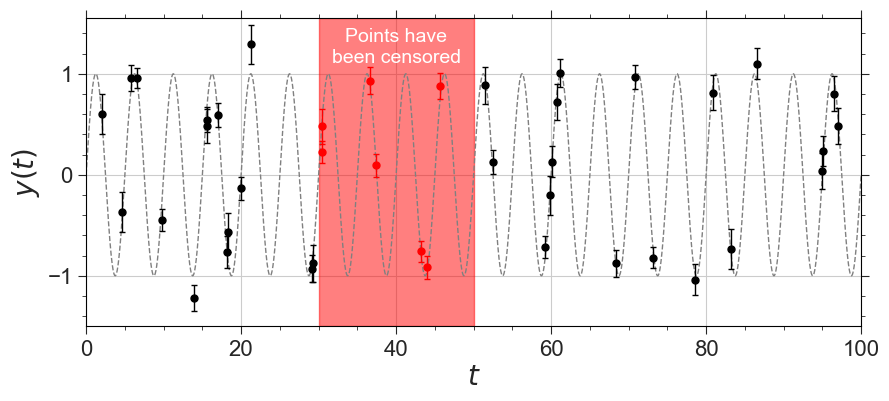

In [197]:
# from astropy.timeseries import LombScargle

# generate fake data
np.random.seed(42)
f_true = 0.2
t_obs = 100 * np.random.random(40)  # 40 observations in 100 days
y_obs = np.sin(2*np.pi * f_true * t_obs)
dy = 0.1 + 0.1 * np.random.random(y_obs.shape)
y_obs += np.random.normal(0, dy)

# censor observations between 30 and 50 days
idx = (t_obs < 30) | (t_obs > 50)
t_obs1 = t_obs[idx]
y_obs1 = y_obs[idx]
dy1 = dy[idx]

y_window = np.ones_like(y_obs1)

t = np.linspace(0, 100, 10000)
y = np.sin(2*np.pi * f_true * t)

# Compute the periodogram
omega = np.linspace(0, 5, 1001)[1:]
# P_obs1 = LombScargle(t_obs, y_obs1, dy1, omega)
# P_window = LombScargle(t_obs, y_window, 1, omega)
# P_true = LombScargle(t, y, 1, omega)

omega /= 2 * np.pi

fig,ax=plt.subplots()
ax.axvspan(30,50,color='r',alpha=0.5)
ax.text(40,1.45,f'Points have\nbeen censored',ha='center',va='top',color='w',size=14)
ax.plot(t, y, '--', c='gray',lw=1)
ax.errorbar(t_obs[~idx], y_obs[~idx], dy[~idx], fmt='.r', capsize=2, elinewidth=1)
ax.errorbar(t_obs1, y_obs1, dy1, fmt='.k', capsize=2, elinewidth=1)
ax.set_xlim(0, 100)
ax.set_ylim(-1.5, 1.55)
ax.set_xlabel('$t$')
ax.set_ylabel('$y(t)$')



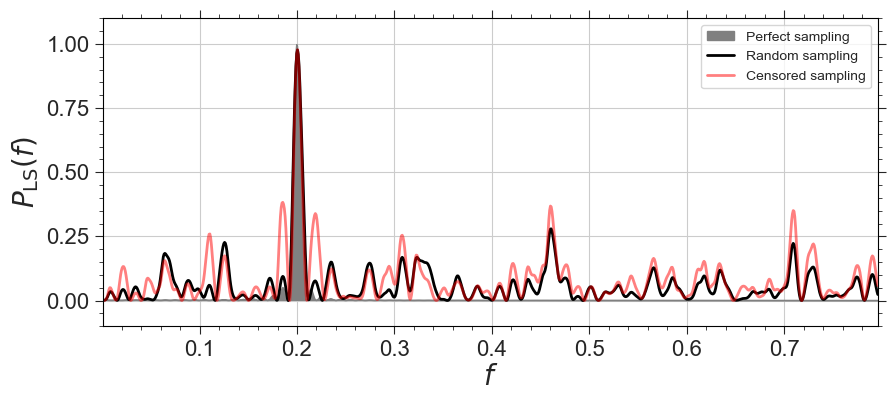

In [198]:

P_LS_true = LombScargle(t, y,fit_mean=False).power(omega)
P_LS_obs = LombScargle(t_obs, y_obs, dy,fit_mean=False).power(omega)
P_LS_obs1 = LombScargle(t_obs1, y_obs1, dy1,fit_mean=False).power(omega)

fig,ax=plt.subplots()

ax.fill(omega, P_LS_true, fc='gray', ec='gray',label='Perfect sampling')
ax.plot(omega, P_LS_obs, '-', c='black',label='Random sampling')
ax.plot(omega, P_LS_obs1, '-', c='r',label='Censored sampling',alpha=0.5)
ax.set_ylim(-0.1, 1.1)
ax.set_xlim(omega[0],omega[-1])
ax.set_xlabel('$f$')
ax.set_ylabel(r'$P_{\rm LS}(f)$')
ax.legend()


# Generalized Lomb-Scargle periodogram 

One condition in which the Lomb-Scargle periodogram can fail to recover the input frequency of the data is when censoring causes a systematic offset between the mean of the data and the mean of the underlying periodic function. In the example below, low values are systematically censored from the dataset, such that the standard Lomb-Scargle periodogram has no peaks that appear significant (close to 1), and the highest peak in fact appears at the incorrect frequency.

In these cases, the Lomb-Scargle periodogram can be generalized to allow for a difference between the true mean of the underlying distribution and that of the data, with the difference being a free parameter to be fit by the model. We can see in the example below that allowing for the mean to vary again recovers the correct peak at high significance.

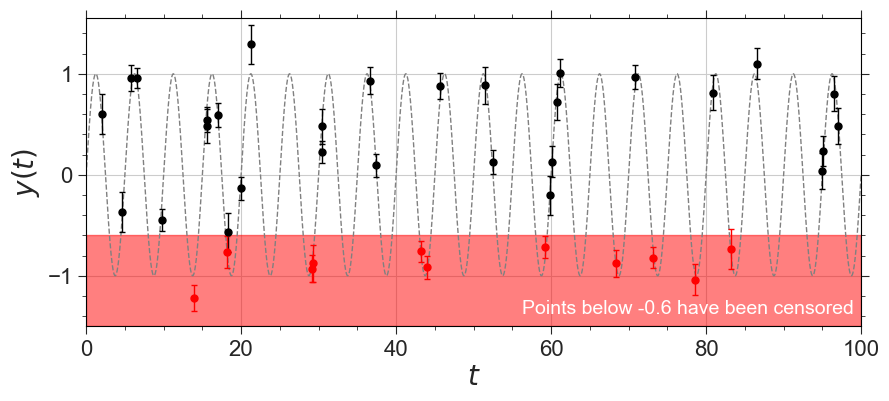

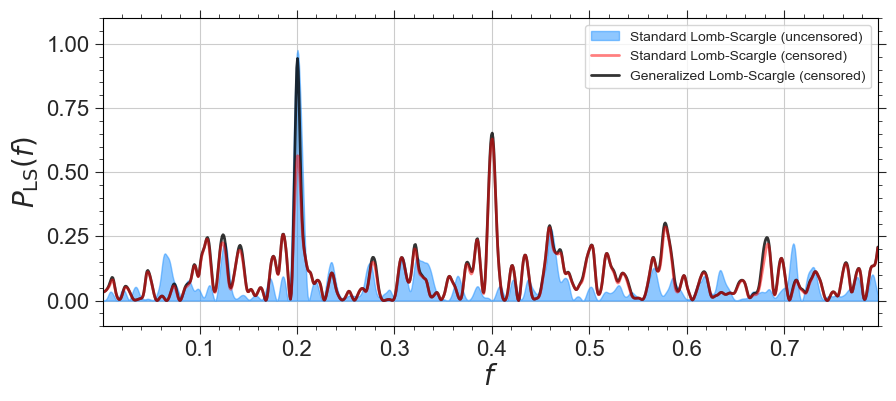

In [175]:
min_y = -0.6
idx = y_obs > min_y
t_obs2 = t_obs[idx]
y_obs2 = y_obs[idx]
dy2 = dy[idx]

# Compute the periodogram
P_LS_obs2_fixd = LombScargle(t_obs2, y_obs2, dy2,fit_mean=False).power(omega)
P_LS_obs2_gnrl = LombScargle(t_obs2, y_obs2, dy2,fit_mean=True).power(omega)

fig,ax=plt.subplots()
ax.plot(t, y, '--', c='gray',lw=1)
ax.errorbar(t_obs2, y_obs2, dy2, fmt='.k', capsize=2, elinewidth=1)
ax.errorbar(t_obs[~idx], y_obs[~idx], dy[~idx], fmt='.r', capsize=2, elinewidth=1)
ax.set_xlim(0, 100)
ax.set_ylim(-1.5, 1.55)
ax.axhspan(-1.5,min_y,color='r',alpha=0.5)
ax.text(0.99,0.04,f'Points below {min_y} have been censored',transform=ax.transAxes,ha='right',color='w',size=14)
ax.set_xlabel('$t$')
ax.set_ylabel('$y(t)$')

fig,ax=plt.subplots()
ax.fill_between(omega, [0]*len(omega), P_LS_obs, color='dodgerblue', alpha=0.5,label='Standard Lomb-Scargle (uncensored)')
ax.plot(omega, P_LS_obs2_fixd, 'r', alpha = 0.5, label='Standard Lomb-Scargle (censored)',zorder=2)
ax.plot(omega, P_LS_obs2_gnrl, 'k', alpha=0.8,label='Generalized Lomb-Scargle (censored)',zorder=1)
ax.set_ylim(-0.1, 1.1)
ax.set_xlim(omega[0],omega[-1])
ax.set_xlabel('$f$')
ax.set_ylabel(r'$P_{\rm LS}(f)$')
ax.legend()


Note also the `nterms` option of `LombScargle` that allows fitting a Truncated Fourier Series instead of a single sinusoid---this may be important for non-sinusoidal periodic behaviors.

## Power spectra
The method of expanding functions in terms of sinusoidal terms or other basis funcations is broadly used in physics and astronomy---as an example in 2D, consider CMB anisotropies and its spherical harmonics expansion

$$\Large \frac{\delta T}{T_0}(\theta, ~\phi) = \sum a_{l, m} Y_{l, m}(\theta, \phi)$$

defining 

$$\Large C_l \equiv \frac{1}{2 l + 1} \sum_m <|a_{l, m}|^2>$$

it is possible to show that for $l \gg 1$, the expectation value for the squared deviation from the average, i.e. the variance, is 

$$\Large \frac{l (l+1) C_l}{2 \pi}$$

![alt text](CMB.jpg "original")
![alt text](Power_Spectrum_Blah.jpg "original")


Further topics in spatial analysis are discussed in another notebook.

# Part 2: Stochastic Autoregressive Models

Even in the case where data is non-period and/or is not well-described by an explicit function of time, the correlations within a time series can still differentiate among different types of processes. For example, even "random" noise can have varying behavior, as in the examples below:

Text(0, 0.5, 'y + offset')

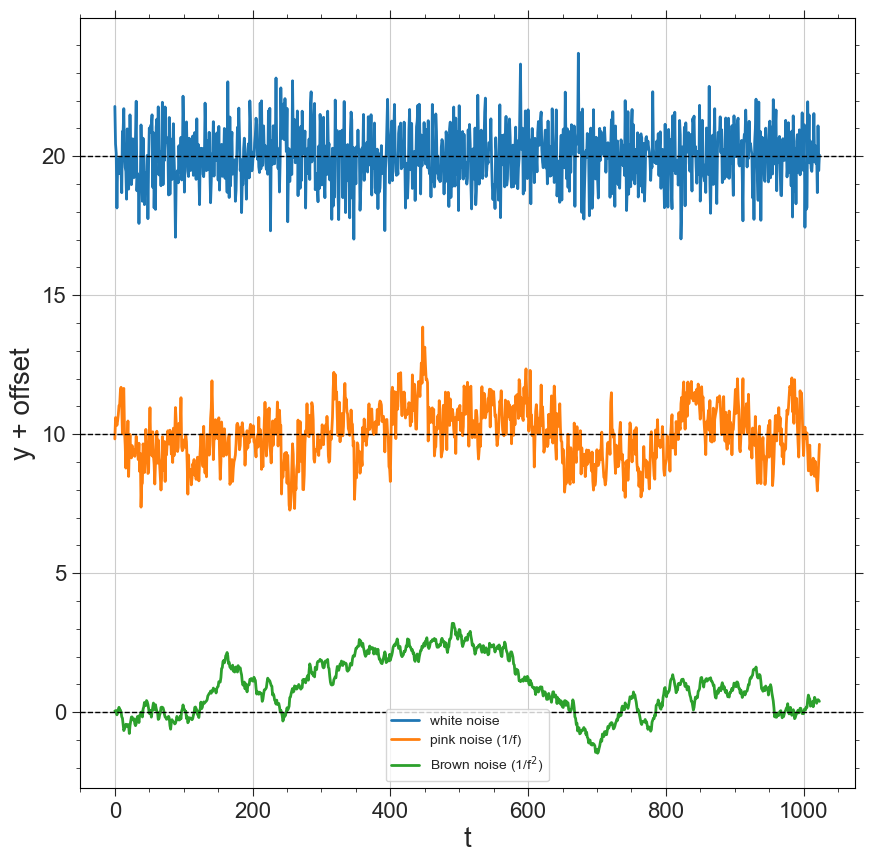

In [208]:
np.random.seed(3)

n=1024
# t = np.linspace(0,10,n)
t = np.arange(n)

# White noise
y_wt = np.random.normal(0,1,n)

# Pink noise
y_orig = np.random.normal(0,1,n)
y_fft = fftpack.fft(y_orig) # compute the FFT
f_fft = fftpack.fftfreq(n)  # compute the frequencies of the FFT
y_fft[f_fft!=0] *= 1/np.sqrt(np.abs(f_fft[f_fft!=0]))   # scale the FFT by the square-root of the frequencies
y_fft[0] = 0
y_pk = fftpack.ifft(y_fft).real # compute the amplitudes from the truncated series

# Brown (or red) noise
y_orig = np.random.normal(0,1,n)
y_br = np.cumsum(y_orig)

y_dict = {'white noise':y_wt,
          'pink noise (1/f)':y_pk/np.std(y_pk),
          'Brown noise (1/f$^2$)':y_br/np.std(y_br)}

fig,ax=plt.subplots(figsize=(10,10))
for i,key in enumerate(y_dict.keys()):
    ax.plot(t,y_dict[key]+20-i*10,label=key)
    ax.axhline(20-i*10,color='k',lw=1,ls='--')
ax.legend()
ax.set_xlabel('t')
ax.set_ylabel('y + offset')


Note that the white noise is constructed as an set of independent random variables (in this case, gaussian-distributed random variables), and the Brown noise is constructed through a random-walk process in which each independent random sample is added to the sum of previous samples. Both of these phenomena (independent variables and random-walk processes) are common in nature and produce very different patterns of noise. As shown below, these types of noise also different power spectra, with white noise have a flat power spectrum (i.e., equal power in all frequencies, or "white") whereas Brown noise has a power spectrum that scales as $1/f^2$ (i.e., more power at lower, "redder" frequencies).

Pink noise also occurs in nature, but the physical basis of this noise is less well understood---in this case, we have constructed it by scaling the Fourier modes to force a $1/f$ (less red than red, hence "pink") spectrum.

/var/folders/6r/klndhhws02j_5lsrsqgz31d40000gq/T/ipykernel_3713/582229649.py:8: RuntimeWarning: divide by zero encountered in divide
  ax.plot(fk,1/(fk/1e-2)**i,color=curve[0].get_color())


Text(0, 0.5, 'PSD(f)')

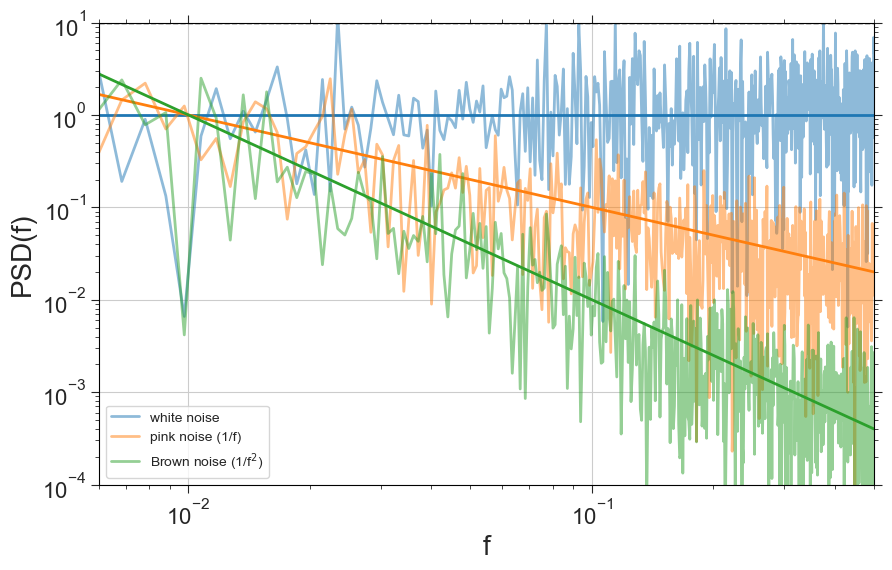

In [209]:
# Plots PSDs for noise

fig,ax=plt.subplots(figsize=(10,6))
for i,key in enumerate(y_dict.keys()):
    fk,PSD = PSD_continuous(t,y_dict[key])
    PSD = PSD/np.median(PSD[np.abs(fk-1e-2)<7e-3])
    curve=ax.plot(fk,PSD,label=key,alpha=0.5)
    ax.plot(fk,1/(fk/1e-2)**i,color=curve[0].get_color())
    ax.axhline(i*10,color='k',lw=1,ls='--')
ax.loglog()
ax.set_xlim(6e-3,5e-1)
ax.set_ylim(1e-4,1e1)
ax.legend()
ax.set_xlabel('f')
ax.set_ylabel('PSD(f)')


## Lag plots

The correlations of the noise properties can also be seen in lag plots, in which the $i^\textrm{th}$ point $y_i$ in the series is plotted vs. the preceding $(i-1)^\textrm{th}$ point $y_{i-1}$. Lag plots can be constructed similarly for other lag times by comparing $y_i$ to $y_{i-n}$ for other values of $n$ as well.

Note that the white noise has no correlations between adjoining points, and the pink noise has a positive correlation with significant scatter. The Brown noise has an extremely strong correlation---it can be shown that the variance of a Brown noise process increases without bound as the overall length of the time series is extended, whereas the variance between $y_i$ and $y_{i-n}$ is fixed, so the lag plot of a Brown noise / random-walk process approaches a straight line over time.

Also shown is an example of periodic behavior in a lag plot---the detailed shape depends on the relationship between the period and the lag time $\Delta t=t_i-t_{i-n}$.

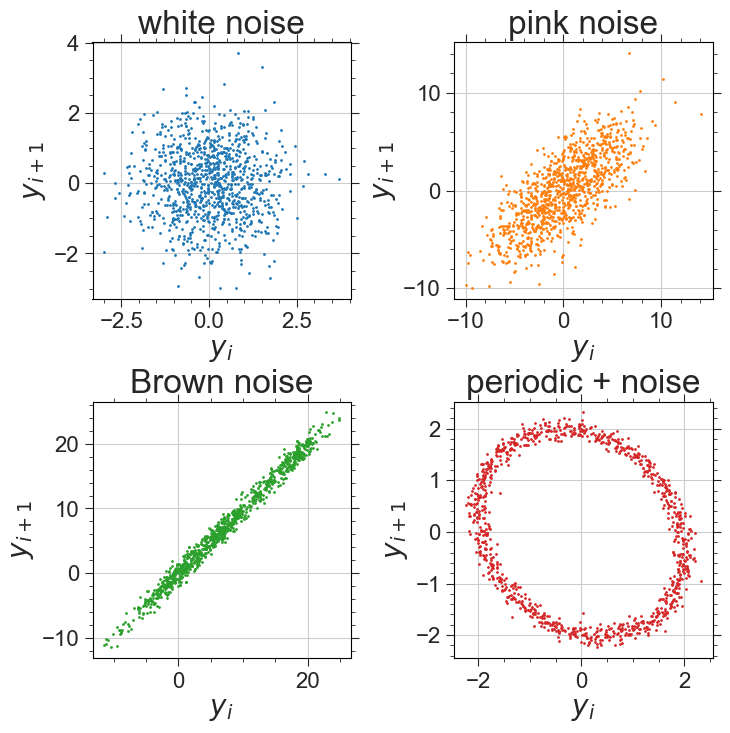

In [181]:
fig,axs=plt.subplots(nrows=2,ncols=2,figsize=(8,8))
axs=axs.flatten()

axs[0].plot(y_wt[:-1],y_wt[1:],'.',ms=2,color='tab:blue')
axs[0].set_title('white noise')
axs[0].set_xlabel('$y_i$')
axs[0].set_ylabel('$y_{i+1}$')
axs[0].axis('equal')

axs[1].plot(y_pk[:-1],y_pk[1:],'.',ms=2,color='tab:orange')
axs[1].set_title('pink noise')
axs[1].set_xlabel('$y_i$')
axs[1].set_ylabel('$y_{i+1}$')
axs[1].axis('equal')

axs[2].plot(y_br[:-1],y_br[1:],'.',ms=2,color='tab:green')
axs[2].set_title('Brown noise')
axs[2].set_xlabel('$y_i$')
axs[2].set_ylabel('$y_{i+1}$')
axs[2].axis('equal')

t_pd = np.arange(1024)
y_pd=2*np.sin(2*np.pi*0.281*t_pd) + np.random.normal(0,0.1,len(t_pd))
axs[3].plot(y_pd[:-1],y_pd[1:],'.',ms=2,color='tab:red')
axs[3].set_title('periodic + noise')
axs[3].set_xlabel('$y_i$')
axs[3].set_ylabel('$y_{i+1}$')
axs[3].axis('equal')

fig.subplots_adjust(wspace=0.4,hspace=0.4)


Finally, the autocorrelation function (ACF) contains similar information to the lag plot for many lag times simultaneously. At times where the ACF is greater (less) than zero, the there is a positive (negative) correlation at the corresponding lag time.

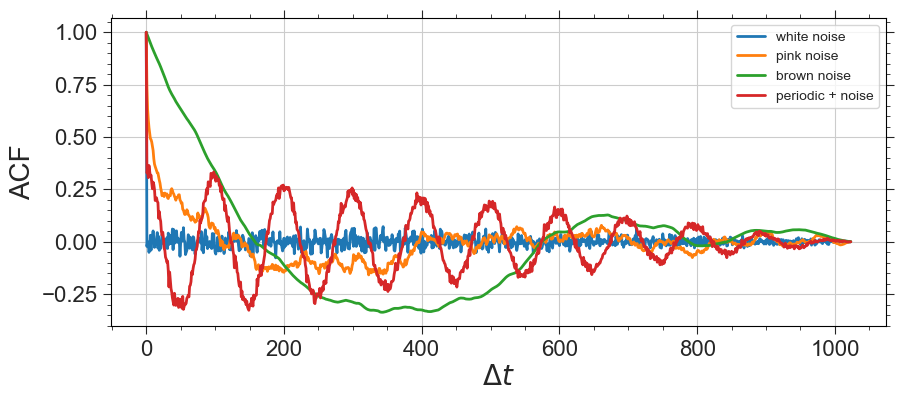

In [218]:
def ACF(y):
    n = len(y)
    ybar = np.mean(y)
    acov = np.zeros(n)
    for j in range(n):
        acov[j] = np.sum([(y[i]-ybar)*(y[i+j]-ybar) for i in range(n-j)])

    return acov/np.sum((y-ybar)**2)

ACF_wt = ACF(y_wt)
ACF_pk = ACF(y_pk)
ACF_br = ACF(y_br)

t_pd = np.arange(1024)
y_pd2 = np.sin(2*np.pi*0.01*t) + np.random.normal(0,1,len(t_pd))
ACF_pd = ACF(y_pd2)


fig,ax=plt.subplots()
ax.plot(t,ACF_wt,label='white noise')
ax.plot(t,ACF_pk,label='pink noise')
ax.plot(t,ACF_br,label='brown noise')
ax.plot(t,ACF_pd,label='periodic + noise')
ax.set_xlabel('$\\Delta t$')
ax.set_ylabel('ACF')
ax.legend()